In [1]:
# if colab

# !pip install pybullet
# !pip install gym
# !apt-get install python-opengl -y
# !apt install xvfb -y
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
import os
import glob
import cv2
import tensorflow as tf 
from tensorflow.keras import layers, models
import numpy as np 
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
import pybullet
import pybullet_envs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from skimage.util.shape import view_as_windows

In [3]:
seed = 654765645
np.random.seed(seed)
tf.random.set_seed(seed)

# check if GPU
print(tf.config.list_physical_devices())
#tf.config.set_memory_growth(physical_devices[1], True)

#set parameters
episodes = 200
episode_steps = 1000
buffer_size = 10000
batch_size = 16


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# colab

# from google.colab import drive
# drive.mount('/content/drive')

# root_dir = "drive/My Drive/"
# base_dir = root_dir + 'CPCtesting'
# os.makedirs(base_dir,exist_ok=True)

# train_dir = base_dir + '/train'
# os.makedirs(train_dir,exist_ok=True)

# model_dir = base_dir + '/model'
# os.makedirs(model_dir,exist_ok=True)

# if local machine
base_dir = "."

train_dir = base_dir + '/train'
os.makedirs(train_dir,exist_ok=True)

model_dir = base_dir + '/model'
os.makedirs(model_dir,exist_ok=True)

logs_base_dir = base_dir + '/logs'

log_dir = base_dir + '/training_logs_save'

reward_dir = base_dir + '/training_rewards_save'


# colab

# from google.colab import drive
# drive.mount('/content/drive')

# root_dir = "drive/My Drive/"
# base_dir = root_dir + 'CPCtesting'
# os.makedirs(base_dir,exist_ok=True)

# train_dir = base_dir + '/train'
# os.makedirs(train_dir,exist_ok=True)

# model_dir = base_dir + '/model'
# os.makedirs(model_dir,exist_ok=True)

# if local machine
base_dir = "."

train_dir = base_dir + '/train'
os.makedirs(train_dir,exist_ok=True)

model_dir = base_dir + '/model'
os.makedirs(model_dir,exist_ok=True)

logs_base_dir = base_dir + '/logs'

log_dir = base_dir + '/training_logs_save'

reward_dir = base_dir + '/training_rewards_save'

cpc_dir = base_dir + '/training_cpcloss_save'


# remove old logs
fileList1 = glob.glob(os.path.join(log_dir , "events.*"))
fileList2 = glob.glob(os.path.join(reward_dir , "events.*"))
fileList3 = glob.glob(os.path.join(cpc_dir,"events.*"))

for filePath in fileList1:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)
        
for filePath in fileList2:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)
for filePath in fileList3:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

# tensorboard directories
# %load_ext tensorboard
os.makedirs(logs_base_dir, exist_ok=True)
os.makedirs(reward_dir,exist_ok=True)
os.makedirs(cpc_dir,exist_ok=True)
# %tensorboard --logdir {logs_base_dir}

# tensorboard
#%load_ext tensorboard
os.makedirs(logs_base_dir, exist_ok=True)
#%tensorboard --logdir {logs_base_dir}

In [5]:
# get data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [6]:
class CPCModel(tf.keras.Model):
    def __init__(self,code_size, predict_terms, terms=4, units=256, image_size=64, channels=3):
        super(CPCModel, self).__init__()
        self.code_size = code_size
        self.predict_terms = predict_terms
        self.terms = terms
        self.units = units
        self.image_size = image_size
        self.channels = channels

        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='linear')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.lrelu1 = tf.keras.layers.LeakyReLU()
        self.conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='linear')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.lrelu2 = tf.keras.layers.LeakyReLU()
        self.conv3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='linear')
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.lrelu3 = tf.keras.layers.LeakyReLU()
        self.conv4 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='linear')
        self.bn4 = tf.keras.layers.BatchNormalization()
        self.lrelu4 = tf.keras.layers.LeakyReLU()
        self.flatten = tf.keras.layers.Flatten()
        self.dense5 = tf.keras.layers.Dense(units=256, activation='linear')
        self.bn5 = tf.keras.layers.BatchNormalization()
        self.lrelu5 = tf.keras.layers.LeakyReLU()
        self.dense6 = tf.keras.layers.Dense(units=code_size, activation='linear', name='encoder_embedding')

        self.gru = tf.keras.layers.GRU(units, return_sequences=False, name='ar_context')
        self.linear = tf.keras.layers.Dense(predict_terms*code_size, activation='linear')    
   
    def encoding(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.lrelu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.lrelu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.lrelu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.lrelu4(x)
        x = self.flatten(x)
        x = self.dense5(x)
        x = self.bn5(x)
        x = self.lrelu5(x)
        z = self.dense6(x)
        #print("encode_shape: ",z.shape)
        return z
  
    def get_context(self, x):
        z = self.encoding(x)
        print("shape check: ", z.shape, ":terms: ", self.terms, ": code size: ", self.code_size)
        z = tf.reshape(z, [-1, self.terms, self.code_size])
        c = self.gru(z)
        return c
    def get_prediction(self, x):
        c = self.get_context(x)
        z_hats = self.linear(c)
        z_hat = tf.reshape(z_hats, [-1, self.predict_terms, self.code_size])
        return z_hat

    def loss(self,weights,biases,labels,inputs,num_samples,num_classes): 
        loss = tf.nn.nce_loss(
        weights, biases, labels, inputs, num_sampled, num_classes, num_true=1,
        sampled_values=None, remove_accidental_hits=False, name='nce_loss')
        return loss
  
    def loss_cpc(self,inputs):
        prob = self.call(inputs)
        #prob = logits - np.max(logits, axis=1)
        print('prob shape: ', prob.shape)
        labels = np.arange(prob.shape[0])
        print('logit shape test: ',prob.shape,": ",labels.shape)
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(labels,prob) #, axis=-1, name=None)
        
        return loss
    
    def call_logits(self,inputs):
        x_tm, x_tp = inputs # get two images
        x_tm = tf.reshape(x_tm, [-1, self.image_size, self.image_size, self.channels]) # reshape image
        x_tp = tf.reshape(x_tp, [-1, self.image_size, self.image_size, self.channels]) # reshape image
        z_hat = self.get_prediction(x_tm)
        z_tp = self.encoding(x_tp)
        z_tp = tf.reshape(z_tp, [-1, self.predict_terms, self.code_size])
        logits = tf.reduce_mean(tf.reduce_mean(z_hat*z_tp, axis=-1), axis=-1, keepdims=True)
        #probs = tf.sigmoid(dot_prods)
        return logits
        
    def call(self,inputs):
        x_tm, x_tp = inputs
        #x_tm = tf.reshape(x_tm, [-1, self.image_size, self.image_size, self.channels])
        #x_tp = tf.reshape(x_tp, [-1, self.image_size, self.image_size, self.channels])
        z_hat = self.get_prediction(x_tm)
        z_tp = self.encoding(x_tp)
        z_tp = tf.reshape(z_tp, [-1, self.predict_terms, self.code_size])
        dot_prods = tf.reduce_mean(tf.reduce_mean(z_hat*z_tp, axis=-1), axis=-1, keepdims=True)
        probs = tf.sigmoid(dot_prods)
        return probs


  # def save(self):
  #       f1 = os.path.join(folder,'target_actor')
  #       f2 = os.path.join(folder, 'target_critic')
  #       f3 = os.path.join(folder, 'actor')
  #       f4 = os.path.join(folder, 'critic')
  #       self.target_actor.save(f1)
  #       self.target_critic.save(f2)
  #       self.actor.save(f3)
  #       self.critic.save(f4)


  # def load(self):
  #   pass

In [7]:
class ReplayBuffer():
    def __init__(self,state_space,action_space,capacity,batch,image_size,channels):
        self.capacity = capacity
        self.batch = batch
        self.elements = 0
        
        self.avaliable_batch = 0
        self.idx = 0
        self.entries = 0 
        
        self.states = np.empty((self.capacity,state_space),dtype = np.float32)
        self.next_states = np.empty((self.capacity,state_space),dtype = np.float32)
        self.actions = np.empty((self.capacity,action_space),dtype = np.float32)
        self.rewards = np.empty((self.capacity,1),dtype = np.float32)
        self.not_dones = np.empty((self.capacity, 1), dtype=np.float32)
        self.image_states = np.empty((self.capacity, image_size,image_size,channels), dtype=np.float32)
        self.image_next_states = np.empty((self.capacity, image_size,image_size,channels), dtype=np.float32)
        
        
    def add(self,state,next_state,action,reward,done,state_image,next_state_image):
        np.copyto(self.states[self.idx], state)
        np.copyto(self.actions[self.idx], action)
        np.copyto(self.rewards[self.idx], reward)
        np.copyto(self.next_states[self.idx], next_state)
        np.copyto(self.not_dones[self.idx], not done)
        np.copyto(self.image_states[self.idx],state_image)
        np.copyto(self.image_next_states[self.idx],state_image)
        #self.avaliable_batch= (self.avaliable_batch + 1) if self.avaliable_batch < self.batch else self.batch
        #self.entries = (self.entries + 1) if self.entries < self.capacity else self.capacity
        self.idx = (self.idx + 1) % self.capacity
        self.entries = np.minimum(self.entries + 1, self.capacity)
        
    def sample(self):
        num = self.entries
        if(num > self.batch):
            num = self.batch
        #print('avaliable_batch: ',self.avaliable_batch, "entries: ", self.entries,'capacity: ', self.capacity)
        idx = np.random.choice(self.entries,size = num,replace=False)
        #print('test idx: ', idx)
        
        states = tf.convert_to_tensor(self.states[idx])
        next_states = tf.convert_to_tensor(self.next_states[idx])
        actions = tf.convert_to_tensor(self.actions[idx])
        rewards = tf.convert_to_tensor(self.rewards[idx])
        not_dones = tf.convert_to_tensor(self.not_dones[idx])
        image_states = tf.convert_to_tensor(self.image_states[idx])
        image_next_states = tf.convert_to_tensor(self.image_next_states[idx])
        
        return states,next_states,actions,rewards,not_dones,image_states,image_next_states                    
        

class Actor(tf.keras.Model):
    def __init__(self,action_space):
        super(Actor,self).__init__()
        
        #params
        self.action_space = action_space
       
        #model
        self.dense1 = tf.keras.layers.Dense(400,
                                            #input_shape = (None,1,1,state_space),
                                            activation = 'relu',
                                            #bias_initializer = tf.random_uniform_initializer(minval=-0.003, maxval=0.003),
                                            bias_initializer = tf.keras.initializers.VarianceScaling(scale=1.0, 
                                                                                                     mode='fan_in', 
                                                                                                     distribution='uniform', 
                                                                                                     seed=seed
                                                                                                    ),
                                            kernel_initializer = tf.keras.initializers.VarianceScaling(scale=1.0, 
                                                                                                       mode='fan_in', 
                                                                                                       distribution='uniform', 
                                                                                                       seed=seed)
                                           )
        self.dense2 = tf.keras.layers.Dense(300,
                                            activation='relu',
                                            #bias_initializer = tf.random_uniform_initializer(minval=-0.003, maxval=0.003),
                                            bias_initializer = tf.keras.initializers.VarianceScaling(scale=1.0, 
                                                                                                       mode='fan_in', 
                                                                                                       distribution='uniform', 
                                                                                                       seed=seed),
                                            kernel_initializer = tf.keras.initializers.VarianceScaling(scale=1.0, 
                                                                                                       mode='fan_in', 
                                                                                                       distribution='uniform', 
                                                                                                       seed=seed)
                                            )
        self.dense3 = tf.keras.layers.Dense(self.action_space,
                                            bias_initializer = tf.random_uniform_initializer(minval=-0.003, 
                                                                                             maxval=0.003,
                                                                                             seed = seed
                                                                                            ),
                                            kernel_initializer = tf.random_uniform_initializer(minval=-0.003, 
                                                                                               maxval=0.003,
                                                                                               seed = seed
                                                                                              )
                                           )
        self.concat1 = tf.keras.layers.Concatenate(axis=-1)
        
    def call(self,x):
        [state,encode_state] = x
        x = self.concat1([state,encode_state])
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic,self).__init__()
        # layers
        self.dense1 = tf.keras.layers.Dense(400,
                                            #input_shape=(1,1,combined_space),
                                            activation = 'relu',
                                            #bias_initializer = tf.random_uniform_initializer(minval=-0.003, maxval=0.003),
                                            bias_initializer = tf.keras.initializers.VarianceScaling(scale=1.0, 
                                                                                                     mode='fan_in', 
                                                                                                     distribution='uniform', 
                                                                                                     seed=seed
                                                                                                    ),
                                            kernel_initializer = tf.keras.initializers.VarianceScaling(scale=1.0, 
                                                                                                       mode='fan_in', 
                                                                                                       distribution='uniform', 
                                                                                                       seed=seed),
                                            kernel_regularizer=tf.keras.regularizers.l2(0.01)
                                           )
        self.concat1 = tf.keras.layers.Concatenate(axis=-1)
        self.dense2 = tf.keras.layers.Dense(300,
                                            activation='relu',
                                            #bias_initializer = tf.random_uniform_initializer(minval=-0.003, maxval=0.003),
                                            bias_initializer = tf.keras.initializers.VarianceScaling(scale=1.0, 
                                                                                                     mode='fan_in', 
                                                                                                     distribution='uniform', 
                                                                                                     seed=seed
                                                                                                    ),
                                            kernel_initializer = tf.keras.initializers.VarianceScaling(scale=1.0, 
                                                                                                       mode='fan_in', 
                                                                                                       distribution='uniform', 
                                                                                                       seed=seed
                                                                                                      ),
                                            kernel_regularizer=tf.keras.regularizers.l2(0.01)
                                            )
        self.dense3 = tf.keras.layers.Dense(1,
                                            bias_initializer = tf.random_uniform_initializer(minval=-0.003, maxval=0.003),
                                            kernel_initializer = tf.random_uniform_initializer(minval=-0.003, 
                                                                                               maxval=0.003,
                                                                                               seed = seed
                                                                                              ),
                                            kernel_regularizer=tf.keras.regularizers.l2(0.01)
                                            ) 
    #predict
    def call(self,data): #states,actions):
        [states,actions] = data
        #x = tf.concat([states,actions],-1)
        y = self.dense1(states)
        x = self.concat1([y,actions])
        x = self.dense2(x)
        x = self.dense3(x)
        return x
    
    
class DDPG():
    def __init__(self,
                 state_space,
                 action_space,
                 image_size,
                 cropped_image_size,
                 capacity = 1000,
                 batch = 1, 
                 tau=0.999,
                 gamma=0.99,
                 actor_lr = 0.001, 
                 critic_lr = 0.0001,
                 variance = 1.0,
                 code_size=128, 
                 predict_terms=4,
                 terms=4, 
                 units=256,
                 channels=3):
        super(DDPG,self).__init__()
        
        #ddpg hyperparameters
        self.batch = batch
        self.tau = tau
        self.gamma = gamma
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.noise_flag = 1.0
        self.std = np.sqrt(variance)
        
        #cpc hyperparameters
        self.image_size = image_size
        self.cropped_image_size = cropped_image_size
        self.code_size = code_size
        self.predict_terms = predict_terms
        self.terms = terms
        self.units = units
        self.channels = channels
        
        #spaces
        self.action_space = action_space
        self.state_space = state_space
        self.combined_space = self.action_space + self.state_space
        
        # replay buffer
        self.replay_buffer = ReplayBuffer(self.state_space,
                                          self.action_space,
                                          capacity,
                                          self.batch,
                                          self.image_size,
                                          self.channels)
        
        # optimizers
        self.opt_actor = tf.keras.optimizers.Adam(actor_lr)
        self.opt_critic = tf.keras.optimizers.Adam(critic_lr)
        self.opt_cpc = tf.keras.optimizers.Adam(1e-3)

        
        #losses
        self.loss_actor = self.loss_actor_func
        self.loss_critic = tf.keras.losses.MSE
        #self.loss_cpc = tf.keras.losses.BinaryCrossentropy(from_logits = True)
        
        #cpc model
        self.cpc = CPCModel(code_size=self.code_size, 
                            predict_terms=self.predict_terms, 
                            terms=self.terms, 
                            units=self.units, 
                            image_size=self.cropped_image_size, 
                            channels=self.channels)
        
        self.cb_cpc = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=2, min_lr=1e-4),
              tf.keras.callbacks.ModelCheckpoint('weights/weights.{epoch:02d}-{val_binary_accuracy:.2f}.cpkt',
                                                  monitor='val_binary_accuracy', save_best_only=True, save_weights_only=True),
              tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3),
              tf.keras.callbacks.TensorBoard()]
        #self.cpc.compile(optimizer=self.opt_cpc, loss='binary_crossentropy', metrics=['binary_accuracy'])
        
        
        
        #rl models
        self.critic = Critic()        
        self.actor = Actor(self.action_space)
        #self.critic.compile(optimizer = self.opt_critic,loss = self.loss_critic)
        #self.actor.compile(optimizer = self.opt_actor,loss = self.loss_actor)
        
        
        #print('model: ',self.critic.summary())
        # target models
        self.target_actor = Actor(self.action_space)
        self.target_critic = Critic()         
        self.target_actor.set_weights(self.actor.get_weights())
        self.target_critic.set_weights(self.critic.get_weights())
        
        #cpc
        #self.cpc = CPC(code_size=128, predict_terms=4, terms=4, units=256, image_size=64, channels=3)
    
    def loss_actor_func(self,states_tuple,actions):
        [states_i,encode_states_i] = states_tuple
        actions = self.actor(states_tuple)
        #stateactions = tf.concat([states,actions],-1)
        #print("state,action shape: ",states.shape,actions.shape)
        Q = self.critic([states_i,actions])
        loss = - tf.reduce_mean(Q)
        return loss
        
    def update_actor(self,states,actions):
        with tf.GradientTape() as tape:
            loss = self.loss_actor(states,actions)

        grad = tape.gradient(loss,self.actor.trainable_variables)
        self.opt_actor.apply_gradients(zip(grad, self.actor.trainable_variables))
        #print('actor loss: ', loss ,"\n" )
        return loss
    
    def set_noise_flag(self,num):
        self.noise_flag = np.float32(not not num)
    
    def continous_noise(self):
        #num = np.random.normal(0,self.std)
        #result = np.full((self.action_space,),num)
        result = np.random.normal(0,self.std,size=(self.action_space,))
        return self.noise_flag * np.clip(result,a_min = -1.0, a_max = 1.0)
    
    def update_critic(self,states_i,actions_i,Q_h):
        match = Q_h.shape[0]
        with tf.GradientTape() as tape:
            Q = self.critic([states_i,actions_i])
            Q = tf.reshape(Q,(1,1,1,match))
            Q_h = tf.reshape(Q_h,(1,1,1,match))
            loss = self.loss_critic(Q,Q_h)

        grad = tape.gradient(loss,self.critic.trainable_variables)
        #grad_magnitude = tf.reduce_sum(grad)
        self.opt_critic.apply_gradients(zip(grad, self.critic.trainable_variables))
        #print('critic loss: ', loss ,"\n" )
        #print("check exploding gradient: ", grad)
        return loss
    
    def random_crop(self,images,output_size): # thanks to CURL developers for the random crop
            """
            Vectorized way to do random crop using sliding windows
            and picking out random ones
            args:
                imgs, batch images with shape (B,C,H,W)
            """
            """ Image shape (batch,width,height,channels)"""
            # batch size
            n = images.shape[0]
            img_size = images.shape[1]
            crop_max = img_size - output_size
            print('crop_max: ', crop_max)
            images = images.numpy() #np.transpose(images, (0, 2, 3, 1))
            w1 = np.random.randint(0, crop_max, n)
            h1 = np.random.randint(0, crop_max, n)
            # creates all sliding windows combinations of size (output_size)
            windows = view_as_windows(
                images, (1, output_size, output_size, 1))[..., 0,:,:, 0]
            # selects a random window for each batch element
            cropped_imgs = windows[np.arange(n), w1, h1]
            cropped_imgs = np.reshape(cropped_imgs,(-1,self.cropped_image_size,self.cropped_image_size,self.channels))
            print("cropped image shape: ",cropped_imgs.shape)
            return cropped_imgs
    
#     def compute_logits(self, z_a, z_pos):
#         """
#         Uses logits trick for CURL:
#         - compute (B,B) matrix z_a (W z_pos.T)
#         - positives are all diagonal elements
#         - negatives are all other elements
#         - to compute loss use multiclass cross entropy with identity matrix for labels
#         """
#         #Wz = tf.linalg.matmul(W, z_pos.T)  # (z_dim,B)
#         logits = tf.linalg.matmul(z_a, tf.transpose(z_pos))  # (B,B)
#         print("logits shape: ", logits.shape)
#         logits = logits - tf.math.maximum(logits, 1)[0][:, None]
#         return logits
    
    
    def update_cpc(self,image_states):
        state_anchor = self.random_crop(image_states,self.cropped_image_size)
        state_pos = self.random_crop(image_states,self.cropped_image_size)
        
        #print("state image shape: ",state_anchor.shape ,": ",state_pos.shape)
        
        with tf.GradientTape() as tape:
            #prob = self.cpc([state_anchor,state_pos])
            #z_a = self.cpc.encoding(state_anchor)
            #z_pos = self.cpc.encoding(state_pos)

            #logits = tf.cast(self.compute_logits(z_a,z_pos),dtype="float32")
            #labels = np.arange(prob.shape[0])
            #labels = tf.cast(tf.reshape(labels,(labels.shape[0],1)),dtype="float32")
            #print('logit shape:', prob.shape,":labels: ",labels.shape)
            cross_entropy = self.cpc.loss_cpc([state_anchor,state_pos]) #labels,prob)
            loss = -tf.reduce_mean(cross_entropy)
        print("loss test: ", loss)
        grad = tape.gradient(cross_entropy,self.cpc.trainable_variables)
        #print("grad: ", grad)
        self.opt_cpc.apply_gradients(zip(grad,self.cpc.trainable_variables))
        return loss
        
        #logits = self.cpc.loss(z_a, z_pos)
        #cpc.fit(data,x=dh_train, epochs=10, validation_data=dh_test, steps_per_epoch=60000//64, validation_steps=10000//64, callbacks=cb)

    
    def store_replay(self,state,next_state,action,reward,done,state_image,next_state_image):
        self.replay_buffer.add(state,next_state,action,reward,done,state_image,next_state_image)
    
    def set_labels(self,states_i,next_states_i,actions_i,rewards_i,terminal_i,state_image_i,next_state_image_i):
        cropped_state_image_i = ddpg.random_crop(state_image_i,self.cropped_image_size)
        encode_state_i = self.cpc.encoding(cropped_state_image_i)
        mu = self.target_actor([next_states_i,encode_state_i])
        #print('ends: ', terminal)
        #print(mu,states)
#         stateactions = tf.concat([states,mu],1)
        Q_h = self.target_critic([next_states_i,mu])
        y = rewards_i + terminal_i*self.gamma * Q_h
        #y = np.concatenate(self.y,0).astype('float32') #.reshape((self.minibatch_size,1,1,1))
        #print('y: ',self.y)
        #y = tf.reshape(y,(self.replay_buffer.batch,1,1,1))
        return y 

    
    def update_target_weights(self):   
        tgt_critic_weight = self.target_critic.get_weights()
        tgt_actor_weight = self.target_actor.get_weights()
        actor_weight = self.actor.get_weights()
        critic_weight = self.critic.get_weights()
        
        
        for idx,(part_tgt,part_net) in enumerate(zip(tgt_actor_weight,actor_weight)):
            tgt_actor_weight[idx] = self.tau*part_tgt + (1.0-self.tau)*part_net
            
        for idx,(part_tgt,part_net) in enumerate(zip(tgt_critic_weight,critic_weight)):
            tgt_critic_weight[idx] = self.tau*part_tgt + (1.0-self.tau)*part_net
        

            
        self.target_actor.set_weights(tgt_actor_weight)
        self.target_critic.set_weights(tgt_critic_weight)
            
    def save(self,filename):
        self.actor.save_weights(filename)
        self.critic.save_weights(filename)
        self.target_actor.save_weights(filename)
        self.target_critic.save_weights(filename)
    
    def load(self,filename):
        self.actor.load_weights(filename)
        self.critic.load_weights(filename)
        self.target_actor.load_weights(filename)
        self.target_critic.load_weights(filename)
            

In [8]:
class DataHandler:
    def __init__(self, 
                 batch_size, 
                 terms, 
                 predict_terms=1, 
                 image_size=64, 
                 color=False, 
                 rescale=True, 
                 aug=True, 
                 is_training=True, 
                 method='cpc'):
        
        self.batch_size = batch_size
        self.terms = terms
        self.predict_terms = predict_terms
        self.image_size = image_size
        self.color = color
        self.rescale = rescale
        self.aug = aug
        self.is_training = is_training
        self.method = method
        self.lena = cv2.imread(os.path.join(base_dir,'lena.jpg'))
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        if self.is_training:
            self.x = x_train/255.0
            self.y = y_train
        else:
            self.x = x_test/255.0
            self.y = y_test
        self.idxs = []
        for i in range(10):
            y = y_train if self.is_training else y_test
            self.idxs.append(np.where(y == i)[0])
        self.n_samples = len(self.y)//terms if self.method == 'cpc' else len(self.y)
        self.shape = self.x.shape
        self.n_batches = self.n_samples//batch_size

    def __iter__(self):
        return self

    def __next__(self):
        return self.cpc_batch() if self.method == 'cpc' else self.benchmark_batch()

    def __len__(self):
        return self.n_batches

    def cpc_batch(self):
        img_labels = np.zeros((self.batch_size, self.terms + self.predict_terms))
        sentence_labels = np.ones((self.batch_size, 1)).astype('int32')
        for bi in range(self.batch_size):
            seed = np.random.randint(10)
            sentence = np.arange(seed, seed + self.terms + self.predict_terms) % 10
            if bi < self.batch_size//2:
                num = np.arange(10)
                predicted = sentence[-self.predict_terms:]
                for i, p in enumerate(predicted):
                    predicted[i] = np.random.choice(num[num != p], 1)
                sentence[-self.predict_terms:] = predicted % 10
                sentence_labels[bi, :] = 0
            img_labels[bi, :] = sentence
        images = self.get_samples(img_labels).reshape((self.batch_size, 
                                                       self.terms+self.predict_terms, 
                                                       self.image_size, 
                                                       self.image_size, 
                                                       3))
        x_images = images[:, :-self.predict_terms, ...]
        y_images = images[:, -self.predict_terms:, ...]
        idx = np.random.choice(self.batch_size, self.batch_size, replace=False)
        return [x_images[idx], y_images[idx]], sentence_labels[idx]

    def get_samples(self, img_labels):
        idx = []
        for label in img_labels.flatten():
            idx.append(np.random.choice(self.idxs[int(label)], 1)[0])
        img_batch = self.x[idx, :, :]
        if self.aug:
            img_batch = self._aug_batch(img_batch)
        return img_batch

    def _aug_batch(self, img_batch):
        if self.image_size != 28:
            resized = []
            for i in range(img_batch.shape[0]):
                resized.append(cv2.resize(img_batch[i], (self.image_size, self.image_size)))
            img_batch = np.stack(resized)
        img_batch = img_batch.reshape((img_batch.shape[0], 1, self.image_size, self.image_size))
        img_batch = np.concatenate([img_batch, img_batch, img_batch], axis=1)

        if self.color:
            img_batch[img_batch >= 0.5] = 1
            img_batch[img_batch < 0.5] = 0
            for i in range(img_batch.shape[0]):
                x_c = np.random.randint(0, self.lena.shape[0] - self.image_size)
                y_c = np.random.randint(0, self.lena.shape[1] - self.image_size)
                img = self.lena[x_c:x_c+self.image_size, y_c:y_c+self.image_size]
                img = np.array(img).transpose((2, 0, 1))/255.0
                for j in range(3):
                    img[j, :, :] = (img[j, :, :] + np.random.uniform(0, 1))/2.0
                img[img_batch[i, :, :, :] == 1] = 1 - img[img_batch[i, :, :, :] == 1]
                img_batch[i, :, :, :] = img

        if self.rescale:
            img_batch = img_batch * 2 - 1
        img_batch = img_batch.transpose((0, 2, 3, 1))
        return img_batch

    def benchmark_batch(self):
        idx = np.random.choice(len(self.x), self.batch_size, replace=False)
        img_batch = self.x[idx]
        label_batch = self.y[idx]
        if self.aug:
            img_batch = self._aug_batch(img_batch)
        label_batch = label_batch.reshape((-1, 1))
        return img_batch, label_batch

In [9]:
# #train loop
# dh_train = DataHandler(64, 4, predict_terms=4, image_size=64, color=True, rescale=True, aug=True, is_training=True, method='cpc')
# dh_test = DataHandler(64, 4, predict_terms=4, image_size=64, color=True, rescale=True, aug=True, is_training=False, method='cpc')
# accuracy_metric_train = tf.keras.metrics.BinaryAccuracy()
# loss_metric_train = tf.keras.metrics.BinaryCrossentropy()
# accuracy_metric_test = tf.keras.metrics.BinaryAccuracy()
# loss_metric_test = tf.keras.metrics.BinaryCrossentropy()
# cpc = CPCModel(code_size=128, predict_terms=4, terms=4, units=256, image_size=64, channels=3)
# optim = tf.keras.optimizers.Adam(1e-3)
# cb = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=2, min_lr=1e-4),
#       tf.keras.callbacks.ModelCheckpoint('weights/weights.{epoch:02d}-{val_binary_accuracy:.2f}.cpkt',
#                                           monitor='val_binary_accuracy', save_best_only=True, save_weights_only=True),
#       tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3),
#       tf.keras.callbacks.TensorBoard()]
# cpc.compile(optimizer=optim, loss='binary_crossentropy', metrics=['binary_accuracy'])
# cpc.fit(x=dh_train, epochs=10, validation_data=dh_test, steps_per_epoch=60000//64, validation_steps=10000//64, callbacks=cb)


In [10]:
#%tensorboard --logdir {logs_base_dir}

In [11]:
# train loop params

episodes = 100
episode_steps = 1000

# buffer params
buffer_size = 10000

# network params
batch_size = 8
tau = 0.999


# image parameter
image_size = 100
cropped_image_size = 84

# pybullet setup
env = gym.make('HalfCheetahBulletEnv-v0')
#env.render(mode = 'human')
env._max_episode_steps = episode_steps



C:\Users\dtara\anaconda3\envs\csci-7000-rl\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [12]:
writer = tf.summary.create_file_writer(log_dir)
writer_reward = tf.summary.create_file_writer(reward_dir)
writer_cpc = tf.summary.create_file_writer(cpc_dir)

#get spaces
state_space = env.observation_space.shape[0]
action_space = env.action_space.shape[0]
print(state_space,action_space)

26 6


t:  0  :episode:  0


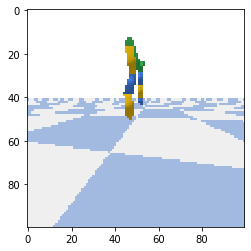

crop_max:  16
cropped image shape:  (1, 84, 84, 4)
test image:  (1, 84, 84, 4)
crop_max:  16
cropped image shape:  (1, 84, 84, 4)
q_loss:  [0.6398181]
crop_max:  16
cropped image shape:  (1, 84, 84, 4)
test shape state_image_i (1, 84, 84, 4)
crop_max:  16
cropped image shape:  (1, 84, 84, 4)
crop_max:  16
cropped image shape:  (1, 84, 84, 4)
shape check:  (1, 128) :terms:  4 : code size:  128


InvalidArgumentError: Input to reshape is a tensor with 128 values, but the requested shape requires a multiple of 512 [Op:Reshape]

In [13]:
state = env.reset()
ddpg = DDPG(action_space=action_space,
          state_space=state_space,
          capacity = buffer_size,
          batch = batch_size,
          tau = 0.999,
          gamma = 0.99,
          actor_lr = 0.0001,
          critic_lr = 0.001,
          variance = 0.3,
          image_size = image_size,
          cropped_image_size = cropped_image_size,
          code_size=128, 
          predict_terms=4,
          terms=4, 
          units=256,
          channels=4)

#fill replay buffer
#env._max_episode_steps = buffer_size
#ddpg.replay_buffer.fill_buffer(buffer_size, state, episode_steps) # self,timesteps,state,prev_timesteps
#env._max_episode_steps = episode_steps


env = gym.wrappers.Monitor(env, "baseline_training", video_callable=lambda episode: True, force="true")
state = env.reset()

for episode in range(episodes):
    sumreward = 0
    for step in range(episode_steps):
        #print(observation)
        print('t: ',step, ' :episode: ',episode)
        #print('state: ',state)
        
        # get action
        state = tf.cast(tf.reshape(state,(1,1,state_space)),dtype='float32')
        state_image = pybullet.getCameraImage(image_size ,image_size)[2] # get rgb image
        plt.imshow(state_image)
        plt.show()
        state_image = tf.reshape(state_image, (1,ddpg.image_size,ddpg.image_size,ddpg.channels))
        state_image = tf.cast(state_image, dtype= "float32") / 255.0
        
        cropped_state_image = ddpg.random_crop(state_image,ddpg.cropped_image_size)
        
        
        print("test image: ",cropped_state_image.shape)
        encode_state = ddpg.cpc.encoding(cropped_state_image)
        encode_state = tf.reshape(encode_state,(1,1,ddpg.code_size))
        #print(state)
        tensor_action = ddpg.actor([state,encode_state]) + ddpg.continous_noise() #ddpg.actor(state)+ddpg.continous_noise()
        action = tensor_action[0][0]
        #print('action: ',action)
        
        #get loss
        #q_loss = ddpg.critic(state,tensor_action)
        
        # get image state
        #state_image = pybullet.getCameraImage(image_size ,image_size)[2] # get rgb image
        #print('state_image: ',state_image,':',type(state_image))
        
        # execute action
        next_state, reward, done, info = env.step(action)
        
        # get image next state
        next_state_image = pybullet.getCameraImage(image_size ,image_size)[2] # get rgb image
        next_state_image = tf.reshape(next_state_image, (-1,ddpg.image_size,ddpg.image_size,ddpg.channels))
        next_state_image = tf.cast(next_state_image, dtype= "float32") / 255.0

        # sum reward
        sumreward += reward

        # store transitions
        ddpg.store_replay(state,next_state,action,reward,done,state_image,next_state_image)
        
        #print('state: ',state)
        #print('next_state: ',next_state)
        #print('action: ',action)
        #print('reward: ',reward)

        #sample minibatch from data
        states_i,next_states_i,actions_i,rewards_i,terminal_i,state_image_i,next_state_image_i = ddpg.replay_buffer.sample()
        
        #set labels y_i
        y = ddpg.set_labels(states_i,next_states_i,actions_i,rewards_i,terminal_i,state_image_i,next_state_image_i)
        
        # update critic net
        q_loss = ddpg.update_critic(states_i, actions_i, y)

        print('q_loss: ', q_loss[0][0].numpy())
        with writer.as_default():
            tf.summary.scalar('Squared QLosses (qtarget - qval)^2', q_loss[0][0][0].numpy(),
                              step=episode * episode_steps + step + 1)
        
        #get cpc encoder
        cropped_state_image_i = ddpg.random_crop(state_image_i,ddpg.cropped_image_size)
        print('test shape state_image_i', cropped_state_image_i.shape)
        encode_state = ddpg.cpc.encoding(cropped_state_image_i)
        
        #update actor net
        ddpg.update_actor([states_i,encode_state],ddpg.actor([states_i,encode_state]))
        #print('weight check: ',rl.actor.get_weights(),'\n')
        
        cpc_loss = ddpg.update_cpc(state_image_i)
        print('test shape cpc loss: ', cpc_loss)
        with writer_cpc.as_default():
            tf.summary.scalar('CPC Loss', cpc_loss,
                              step=episode * episode_steps + step + 1)
        
        #update target nets
        ddpg.update_target_weights()
        
        state = next_state
        if done:
            state = env.reset()
            #rewards[episode] = sumreward
            #ddpg.save(base_dir+'/baseline_model')
            print("Episode {} finished after {} timesteps with reward {}".format(episode,step+1,sumreward))
            with writer_reward.as_default():
                tf.summary.scalar('Episode sum reward', sumreward,step=episode)
            break
print('done') 
ddpg.save(base_dir + '/baseline_model')

 https://datascience.stackexchange.com/questions/13216/intuitive-explanation-of-noise-contrastive-estimation-nce-loss(InfoNCE Loss )
<br>
Representation Learning with Contrastive Predictive Coding
<br>
https://github.com/gdao-research/cpc/blob/master/cpc/data_handler.py (CPC)
<br>
https://github.com/davidtellez/contrastive-predictive-coding/blob/master/train_model.py (CPC)
<br>
https://github.com/MishaLaskin/curl/blob/23b0880708c29b078b0a25e62ff31fb587587b18/utils.py#L123 (replay buffer and SAC)
<br>
https://github.com/marload/DeepRL-TensorFlow2/blob/master/A2C/A2C_Discrete.py (A2C)
<br>
https://github.com/germain-hug/Deep-RL-Keras/blob/master/A3C/a3c.py (A3C)
<br>
https://github.com/tensorflow/agents/blob/v0.5.0/tf_agents/agents/sac/sac_agent.py (SAC)
<br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate (needed to combine inputs)